# Reporting dashboard
## Transition frequencies


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from datetime import date
from IPython.display import display

import src.compute.changelogs as changelogs
from src.compute.utils import Interval
from src.db.utils import SnowflakeWrapper

conn = SnowflakeWrapper.create_snowflake_connection()
sw = SnowflakeWrapper(conn)

def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100

First, we need to define an interval in which we will operate:

In [10]:
active_interval: Interval = Interval(
    # fromDate=date(2019, 7, 1), # year, month, day
    # toDate=date(2019, 10, 1),
    fromDate=date(2019, 10, 1), # year, month, day
    toDate=date(2020, 1, 1)
)
print(active_interval)

('2019-10-01', '2020-01-01')


Number of actions on the given interval

In [3]:
active_cards = changelogs.transition_frequency(sw, interval=active_interval, by_status=False, by_week=False)
print(f"Cards active in the interval {active_interval}: {active_cards['TotalTransitions'][0]}")

Cards active in the interval ('2019-10-01', '2020-01-01'): 5929


In [4]:
print(f"Number of transitions in the interval, by week:")
frequency_week = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_status=False, by_week=True, order="ASC")
display(frequency_week)

Most frequent transitions in the interval, by week:


,Year,WeekOfYear,TotalTransitions
0,2019,40.00000,327
1,2019,41.00000,362
2,2019,42.00000,391
3,2019,43.00000,436
4,2019,44.00000,289
5,2019,45.00000,455
6,2019,46.00000,581
7,2019,47.00000,421
8,2019,48.00000,379
9,2019,49.00000,645


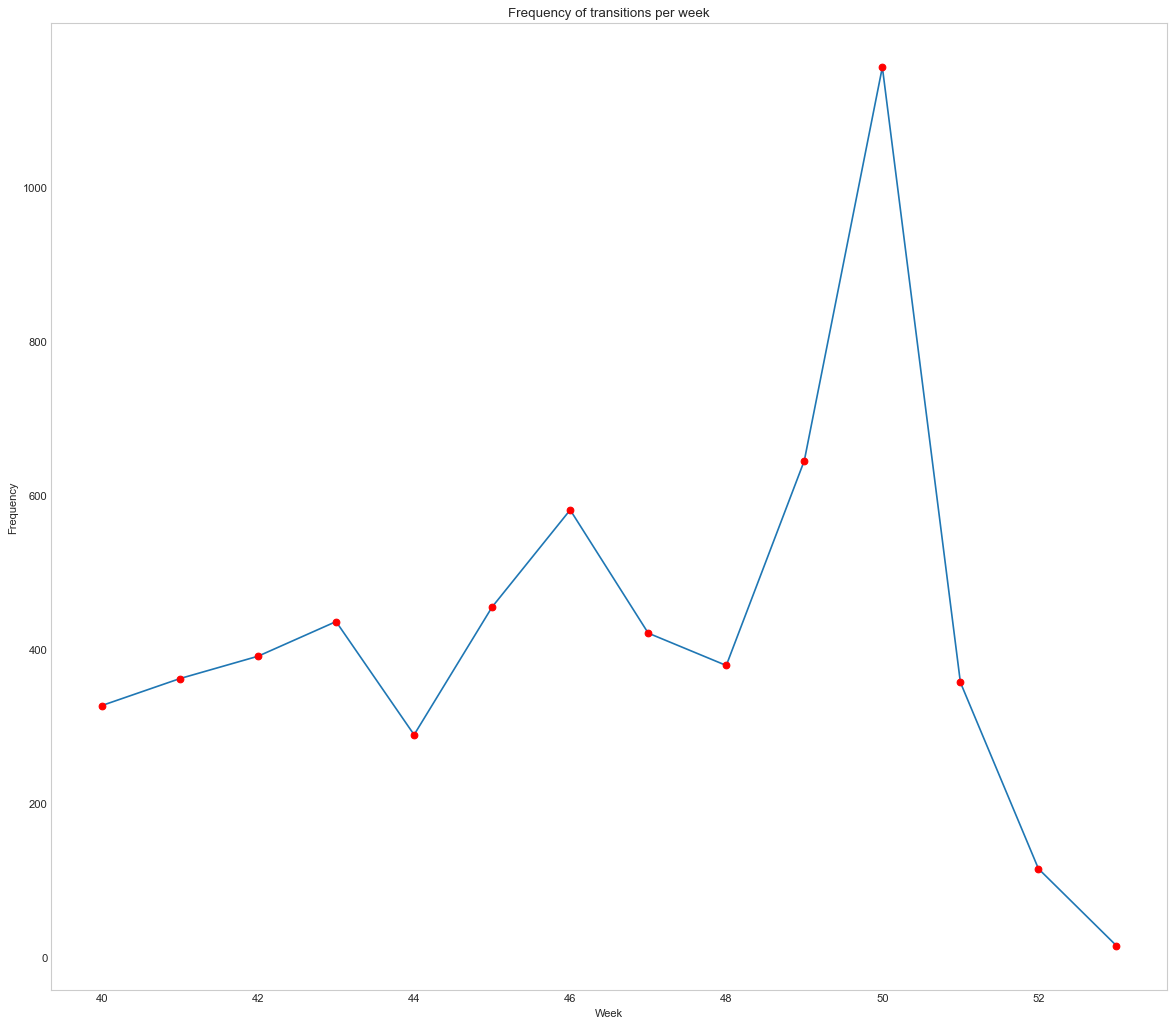

In [5]:
def draw_per_week():
    fig, ax = plt.subplots(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    ax.set_xlabel("Week")
    ax.set_ylabel("Frequency")
    ax.set_title("Frequency of transitions per week")
    ax.grid()
    x_data = frequency_week["WeekOfYear"]
    y_data = frequency_week["TotalTransitions"]
    max_y = max(y_data)
    ax.plot(x_data, y_data)
    ax.plot(x_data, y_data, 'ro')
    ax.set_yticks(range(0, max_y + 10, roundup(int(max_y/10))), minor=False)
draw_per_week()

In [6]:
print(f"Most frequent transitions in the interval:")
most_frequent = changelogs.transition_frequency(sw, interval=active_interval, limit=10, order="DESC")
display(most_frequent)

Most frequent transitions in the interval:


,Transition,TotalTransitions
0,Ready for dev -> Development,480
1,Development -> Code review,450
2,Code review -> Testing,430
3,In Backlog -> Cancelled,398
4,Testing -> Master,380
5,Master -> Live,364
6,Code review -> Needs CR fixes,277
7,Pending Review -> Review,275
8,Needs CR fixes -> Code review,267
9,Review -> Ready for dev,256


In [7]:
print(f"Least frequent transitions in the interval:")
least_frequent = changelogs.transition_frequency(sw, interval=active_interval, limit=10, order="ASC")
display(least_frequent)

Least frequent transitions in the interval:


,Transition,TotalTransitions
0,On Hold -> Done,1
1,Done -> Testing,1
2,Cancelled -> To-Do,1
3,Done -> Work in Progress,1
4,Ready for dev -> On Hold,1
5,To-Do -> Spec design,1
6,Needs QA fixes -> Testing On Hold,1
7,On Hold -> Development Backlog,1
8,Needs SR feedback -> Cancelled,1
9,In Backlog -> Pending Review,1


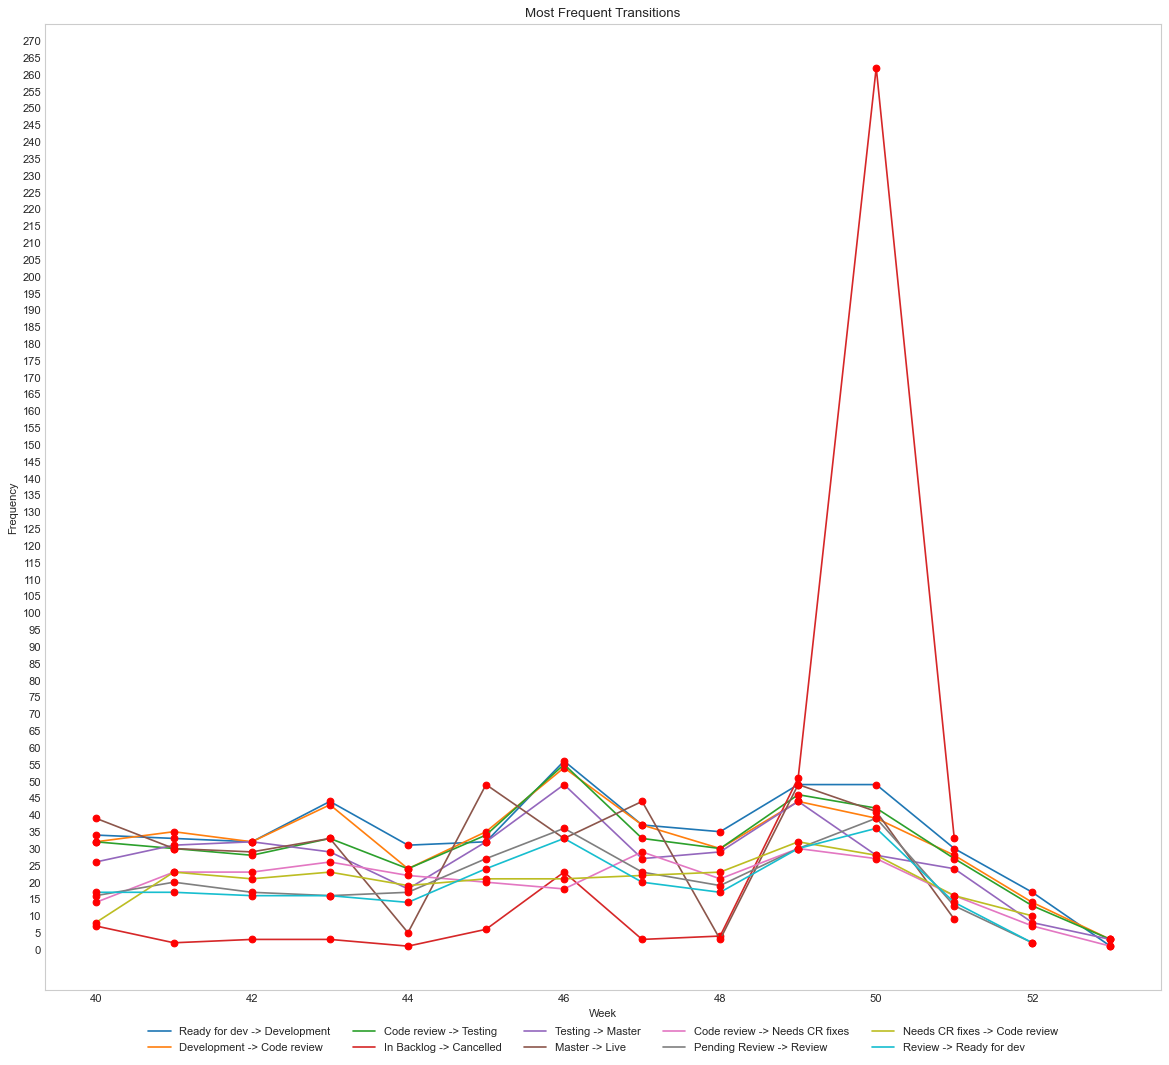

In [9]:
most_frequent_week = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_week=True, order="ASC")
display(most_frequent_week)
def draw_most_frequent_per_week():
    fig, ax = plt.subplots(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    max_y = -1
    for _, row in most_frequent.iterrows():
        data = most_frequent_week[most_frequent_week["Transition"].isin([row["Transition"]])]
        x_data = data["WeekOfYear"]
        y_data = data["TotalTransitions"]
        max_y = max(max(y_data), max_y)
        ax.plot(x_data, y_data, label=row["Transition"])
        ax.plot(x_data, y_data, 'ro')
    
    ax.set_xlabel("Week")
    ax.set_ylabel("Frequency")
    ax.set_title("Most Frequent Transitions")
    ax.grid()
    ax.set_yticks(range(0, max_y + 10, 5), minor=False)
    cols = int(len(most_frequent)/2)
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=cols)
draw_most_frequent_per_week()